# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

 # Построение модели для рекомендации тарифов
 
Исходные данные от заказчика:
 Требуется построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
 
 Предоставлен датасет с данными о поведении клиентов, которые перешли на тарифы  «Смарт» или «Ультра». Предобработка данных выполнена в предыдущем проекте. 
 
 Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 
  
 План работы:

- Изучение общей информации о данных
- Разделение данных на `обучающую`, `валидационную` и `тестовую` выборки
- Исследование качеств разных моделей с разными гиперпараметрами
- Выбор оптимальной модели и ее гиперпараметров
- Проверка качества модели на тестовой выборке
- Проверка модели на вменяемость


Описание данных:

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [1]:
# Ячейка с импортом библиотек, импорт происходит только в этой ячейке

import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Ячейка с c начальными настройками Pandas
pd.set_option('display.max_columns', 50) 
pd.options.mode.chained_assignment = None

In [3]:
# Ячейка с c глобальными переменными к проекту
RANDOM_STATE = 3141592654


## Открытие и изучение файла

In [4]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

display(df.head(12))
df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Значения во всех колонках - вещественные числа, кроме колонки `is_ultra` - это категориальное, булево значение, определяющее принадлежность к тарифу УЛЬТРА, если 1 и Смарт, если 0

Значения в колонках `calls` и `messages` по смыслу должны быть целочисленными, проверим это:

In [5]:
def is_integer(df_name, list_of_columns): # Функция is_integer принимает имя датасета и список колонок для проверки.
    for column in list_of_columns:        # и выводит лог проверки на целочисленность. Возвращает None
        try:
            if all(x.is_integer() for x in df_name[column]):
                print('ОК. Значения в колонке "', column,'" целочисленные.', sep='')
            else:
                print('Ошибка. Обнаружены дробные значения в колонке "', column,'", требуется предобработка.', sep='')
        except:
            print('Ошибка. Колонка с именем "', column,'" не найдена, проверьте ввод', sep='')

is_integer(df, ['calls', 'messages'])


ОК. Значения в колонке "calls" целочисленные.
ОК. Значения в колонке "messages" целочисленные.


Все значения в колонках `calls` и `messages` с большой долей вероятности не дробные, преобразовывать их не будем.

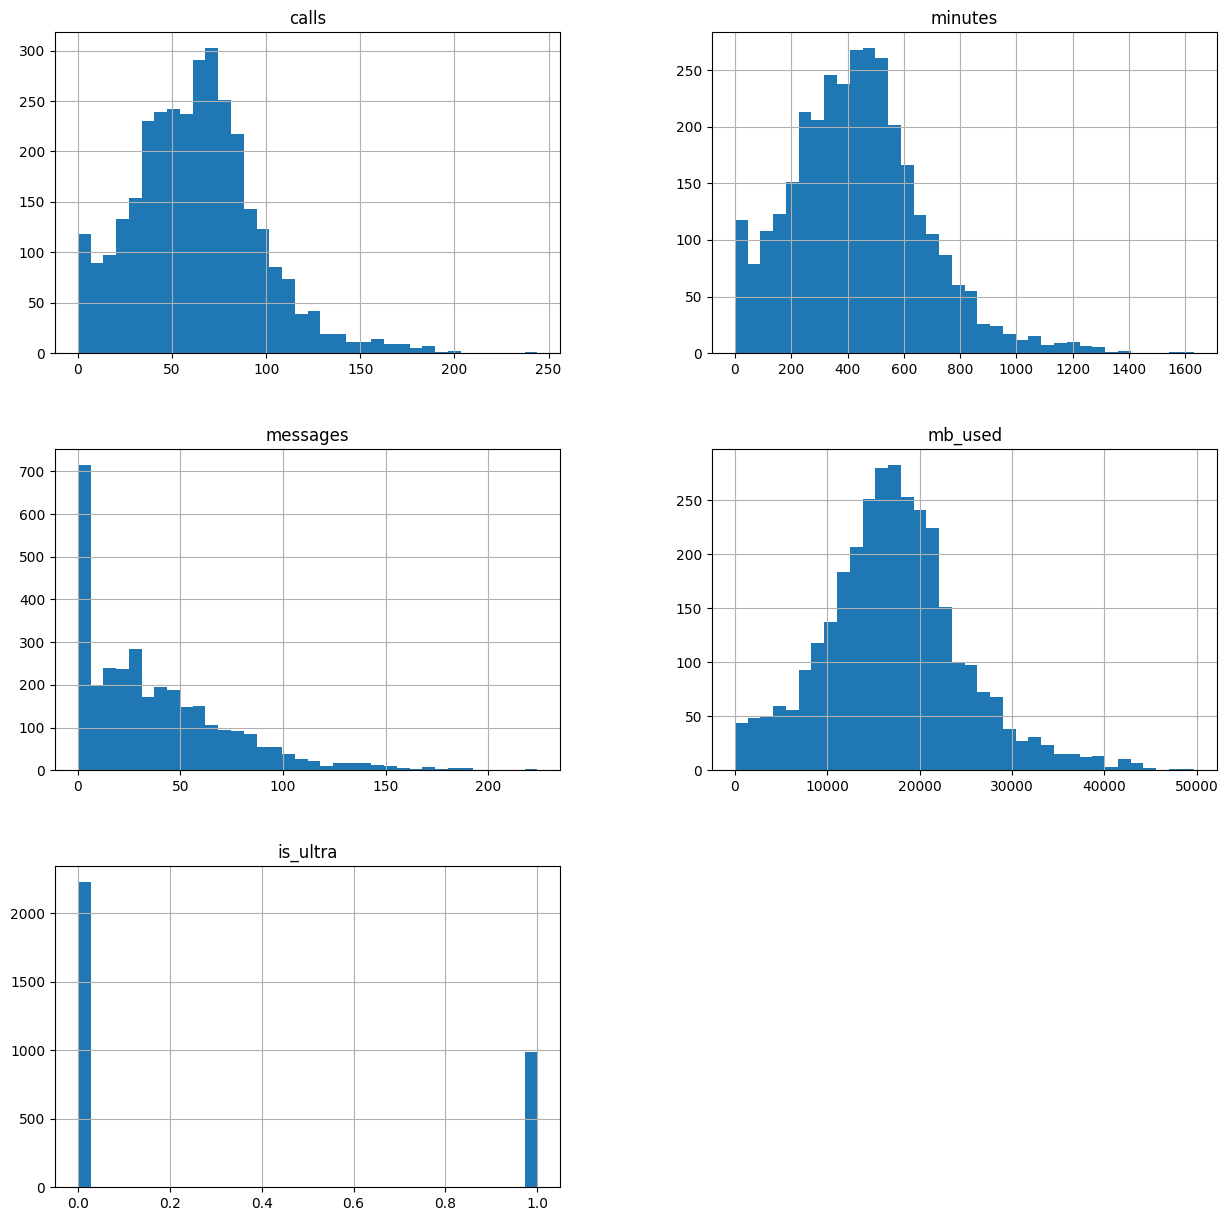

In [6]:
df.hist(figsize=(15, 15), bins = 36);

**Вывод по разделу 1**

- В данных 5 колонок (признаков) и 3214 строк (объектов)
- Пропуски отсутствуют
- Распределение данных для количества звонков и количества сообщений, судя по гистограммам, в целом соответствуют распределению Пуасонна.
- Распределение длительности звонков и  объема израсходованного трафика близко к нормальному распределению.
- Количество пользователей тарифа `Смарт` более чем в два раза превышает количество пользователей тарифа `Ультра`. Для обучения модели требуется стратифицированная выборка.

## Разделение данных на выборки

Согласно заданию тестовую выборку мы берем из исходного набора данных. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. 

Размеры тестового и валидационного наборов примем равными. 

Исходные данные разобъем в соотношении 3:1:1

Так как в целевом признаке есть дисбаланс классов, выборки стратифицируем с помощью параметра stratify в train_test_split. 
Для этого создадим массив с распределением целевого признака как в исходном датасете.

Также определим признаки для моделей машинного обучения, для каждой из выборок:

features — признаки (`calls`, `messages`, `minutes`, `mb_used`);
target — целевой признак (`is_ultra`).

In [7]:
def make_stratify_array(df_name, boolean_column_name):      # Функция make_stratify_array принимает df_name = имя датасета 
    try:                                                    # и boolean_column_name = имя колонки с булевыми значениями
        if len(df_name[boolean_column_name].unique()) == 2: # возвращает series со схожим распределением булевых значений
            stratify_array = pd.Series([df_name[boolean_column_name].unique()[0]]*len(df_name))
            for i in range(len(df_name[df_name[boolean_column_name] == df_name[boolean_column_name].unique()[1]])):
                #stratify_array[random.randint(0, len(df_name))] = 1
                stratify_array[i] = 1
            return stratify_array
        else:
            print('Колонка "', boolean_column_name, '" не содержит булевы значения', sep ='')
    except:
        print('Не найдено имя колонки "', boolean_column_name, '".', sep ='')

In [8]:
# первый вариант, разбитие на выборки в train_test_split, выделение целевого параметра отдельно вручную (в следуюих ячейках)
#df_train, df_valid_and_test = train_test_split(
#    df, test_size=0.4, random_state=RANDOM_STATE, stratify=make_stratify_array(df, 'is_ultra')) 

#df_valid, df_test = train_test_split(
#    df_valid_and_test, test_size=0.5, random_state=RANDOM_STATE, stratify=make_stratify_array(df_valid_and_test, 'is_ultra')) 

In [9]:
train, validate, test, = \
        np.split(df.sample(frac=1, random_state=RANDOM_STATE), [int(.6*len(df)), int(.8*len(df))] )

#print(df.sample(frac=1, random_state=RANDOM_STATE))
print(train.shape)
print(validate.shape)
print(test.shape)
#print(test2.shape)

(1928, 5)
(643, 5)
(643, 5)


In [10]:
# второй вариант, разбитие на выборки и выделение целевого параметра в train_test_split
df_train, df_valid_and_test, target_train, target_valid_and_test  = train_test_split(
    df, 
    df['is_ultra'],  
    test_size=0.4, 
    random_state=RANDOM_STATE, 
    stratify=make_stratify_array(df, 'is_ultra')) 

features_train = df_train.drop(['is_ultra'], axis=1)

df_valid, df_test, target_valid, target_test  = train_test_split(
    df_valid_and_test, 
    df_valid_and_test['is_ultra'], 
    test_size=0.5, 
    random_state=RANDOM_STATE, 
    stratify=make_stratify_array(df_valid_and_test, 'is_ultra'))

features_valid = df_valid.drop(['is_ultra'], axis=1)
features_test = df_test.drop(['is_ultra'], axis=1)

In [11]:
# Закомментировано для проверки метода выделения целевых параметров при помощи train_test_split
#features_train = df_train.drop(['is_ultra'], axis=1)
#target_train = df_train['is_ultra']
#features_valid = df_valid.drop(['is_ultra'], axis=1)
#target_valid = df_valid['is_ultra']
#features_test = df_test.drop(['is_ultra'], axis=1)
#target_test = df_test['is_ultra']

**Вывод по разделу 2**

- Методом train_test_split исходный датасет разбит на 3 выборки: обучающую, валидационную и тестовую в соотношении 3:1:1
- Определены признаки для моделей машинного обучения:
  - целевой признак: `is_ultra`
  - признаки: `calls`, `messages`, `minutes`, `mb_used`

## Исследование моделей

Определение подходящего тарифа - задача бинарной классификации, т.к. предлагаемых тарифов всего два.

Для задач предсказания нужного тарифа рассмотрим три модели машинного обучения:

- дерево решений
- случайный лес
- логистическую регрессию

Исходя из практики машинного обучения модели имеют следующие характеристики:

- Качество (accuracy) - качество предсказания, т.е. общее количество верных предсказаний ко всему количеству объектов
- Точность (precision) - показывает, какая доля тарифов, выбранных для некоторых пользователей, действительно соответствуют выбранным пользователями тарифам.
- Полнота (recall) выявляет, какую часть реальных тарифов пользователя модель определила верно.
- Скорость работы модели

Для задач настоящего исследования выбрана метрика Качество (accuracy), так как каждое неправильное предсказание — это неверная подсказка и потенциальная упущенная выгода для компании. И наоборот: чем выше точность классификации, тем больше прибыли принесёт продукт.

Объединим критерии в таблицу с указанием характеристик для каждой из выбранных моделей:

|Название|Качество (accuracy)|Скорость
|:-------------|:-------------|:-------------
|Дерево решений|Низкое|Высокая
|Случайный лес|Высокое|Низкая
|Логистическая регрессия|Среднее|Высокая

Так как исследование выполняется не "на лету", а для поиска конкретного ответа на заданных данных, то в приоритете высокое качество предсказаний модели, то есть оптимальной моделью для использования можно выбрать `Случайный лес`.

Однако в целях изучения материала в проекте будут рассмотрены все три модели c различными гиперпараметрами.

### Исследование модели `Дерево решений`

Самый важный гиперпараметр решающего дерева — `max_depth` (максимальная глубина). 
Для задач упрощения дерева рассмотрим также параметр `min_samples_split`. Этот гиперпараметр запрещает создавать узлы, в которые попадает слишком мало объектов обучающей выборки.


Обучим модели решающего дерева для задачи классификации:
- с максимальной глубиной от 1 до 10.
- c минимальным количеством объектов в узлах от 2 до 3  

Для каждой модели посчитаем качество (accuracy) на валидационной выборке и выберем наилучшую комбинацию:

In [12]:
best_result_tree = 0
best_depth = 0
best_min_samples = 0

for min_samples in range(2, 4):
    for depth in range(1, 11):
        model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_split=min_samples)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result_tree:
            best_result_tree = result
            best_depth = depth
            best_min_samples = min_samples
        
print('Accuracy наилучшей модели на валидационной выборке:', best_result_tree)
print('Глубина дерева:', best_depth)
print('Мин. кол-во объектов в узлах:', best_min_samples)

Accuracy наилучшей модели на валидационной выборке: 0.7869362363919129
Глубина дерева: 8
Мин. кол-во объектов в узлах: 2


### Исследование модели `Случайный лес`

Для этой модели рассмотрим гиперпараметры `n_estimators` (количество «деревьев»), `max_depth` (максимальная глубина) и `min_samples_split` (минимальное количество объектов в узлах). 

Обучим модели случайного леса для задачи классификации:
- с количеством деревьев: от 10 до 50 с шагом 10
- с максимальной глубиной от 1 до 10
- c минимальным количеством объектов в узлах от 2 до 3  

Для каждой модели посчитаем качество (accuracy) на валидационной выборке и выберем наилучшую комбинацию:

In [13]:
best_result_forest = 0
best_est = 0
best_depth_forest = 0
best_min_samples_forest = 0

for min_samples in range(2, 4):
    for est in range(10, 51, 10):
        for depth in range (1, 11):
            model = RandomForestClassifier(
                random_state=RANDOM_STATE,
                n_estimators=est, 
                max_depth=depth, 
                min_samples_split=min_samples) 
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions_valid)
            if result > best_result_forest:
                best_result_forest = result
                best_est = est
                best_depth_forest = depth
                best_min_samples_forest = min_samples

print('Accuracy наилучшей модели на валидационной выборке:', best_result_forest)
print('Количество деревьев:', best_est)
print('Глубина дерева:', best_depth_forest)
print('Мин. кол-во объектов в узлах:', best_min_samples_forest)

Accuracy наилучшей модели на валидационной выборке: 0.8087091757387247
Количество деревьев: 40
Глубина дерева: 10
Мин. кол-во объектов в узлах: 2


### Исследование модели `Логистическая регрессия`

Для этой модели рассмотрим гиперпараметры `solver`='lbfgs' (алгоритм) и `max_iter`=1000. 

Алгоритм 'lbfgs' — один из самых распространённых. Он подходит для большинства задач. Гиперпараметром `max_iter` задаётся максимальное количество итераций обучения.

In [14]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
model.predict(features_valid)
best_result_lr = accuracy_score(target_valid, predictions_valid)
print('Accuracy модели на валидационной выборке:', best_result_lr)

Accuracy модели на валидационной выборке: 0.80248833592535


Дерево решений             0.786936
Случайный лес              0.808709
Логистическая регрессия    0.802488
dtype: float64

Выбранная модель с лучшим значением метрики: Случайный лес    0.808709
dtype: float64


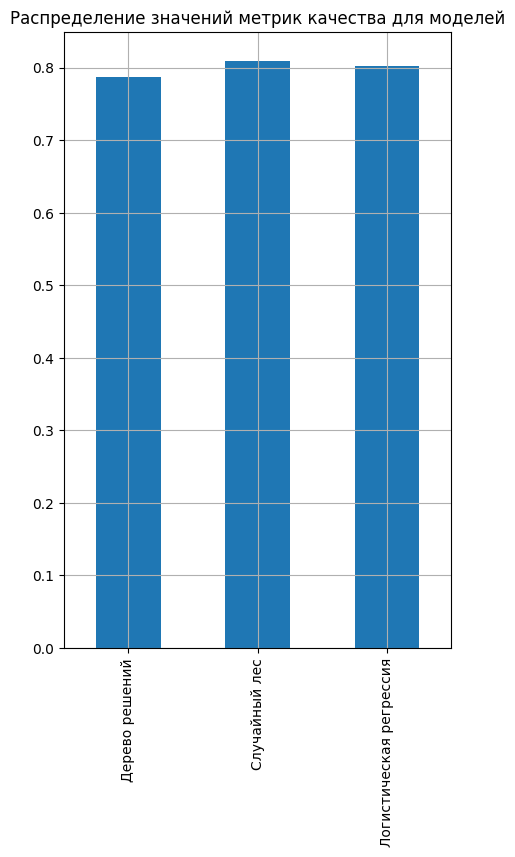

In [15]:
models_accuracy = pd.Series(data=[best_result_tree, best_result_forest, best_result_lr], 
                            index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия'])

models_accuracy.plot(kind='bar', grid=True, figsize=(5,8), title='Распределение значений метрик качества для моделей')

display(models_accuracy);
print('Выбранная модель с лучшим значением метрики:', models_accuracy.loc[models_accuracy == models_accuracy.max()]);


**Вывод по разделу 3**

- На данном этапе были выбраны 3 модели для исследования: `Дерево решений`, `Случайный лес`, `Логистическая регрессия` 
- Исходя из практики машинного обучения и особенностей конкретного задания:

  - для моделей принята метрика точности: `Качество (accuracy)`
  - оптимальной моделью для использования выбран `Случайный лес`, как наилучший по качеству предсказаний
  - в проекте исследованы три модели c различными гиперпараметрами
  
- в результате исследования моделей было определены значения метрик качества и оптимальные гиперпараметры:

|Название|Качество (accuracy)|Гиперпараметры
|:-------------|:-------------|:-------------
|Дерево решений|0.7869362363919129|Глубина дерева = 8, Мин. кол-во объектов в узлах: 2
|Случайный лес|0.8087091757387247|Количество деревьев: 40, Максимальная глубина: 10, Мин. кол-во объектов в узлах: 2
|Логистическая регрессия|0.80248833592535|Алгоритм ='lbfgs' и max_iter=1000

- По итогу исследований для проверки на тестовой выборке принята модель `Случайный лес`, количество деревьев: 40, максимальная глубина: 10, минимальное количество объектов в узлах: 2


## Проверка модели на тестовой выборке

In [16]:
print('Проверим выбранную модель Случайный лес, со следующими гиперпараметрами:')
print(' - n_estimators =',best_est, '(количество деревьев)')
print(' - max_depth_forest =',best_depth_forest, '(максимальная глубина)')
print(' - min_samples_split_forest =',best_min_samples_forest, '(мин. кол-во объектов в узлах)')

Проверим выбранную модель Случайный лес, со следующими гиперпараметрами:
 - n_estimators = 40 (количество деревьев)
 - max_depth_forest = 10 (максимальная глубина)
 - min_samples_split_forest = 2 (мин. кол-во объектов в узлах)


In [17]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=best_est, max_depth=best_depth_forest, min_samples_split=best_min_samples_forest) 
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)

print('Качество (accuracy) модели на тестовой выборке:', result_test)
if result_test >= 0.75:
    print('Удалось достичь accuracy не меньше 0.75')
else:
    print('Аccuracy меньше 0.75, требуется настройка гиперпараметров.')
print('Качество (accuracy) модели на валидационной выборке:', models_accuracy.loc[models_accuracy == models_accuracy.max()][0])


Качество (accuracy) модели на тестовой выборке: 0.8304821150855366
Удалось достичь accuracy не меньше 0.75
Качество (accuracy) модели на валидационной выборке: 0.8087091757387247


**Вывод по разделу 4**

- Выбранная модель `Случайный лес` с гиперпараметрами количество деревьев: 40, максимальная глубина: 10, мин. кол-во объектов в узлах: 2  проверена на тестовой выборке 
- Качество (accuracy) выбранной модели на тестовой выборке не меньше 0.75
- Качество (accuracy) выбранной модели на тестовой выборке близко к качеству на валидационной выборке (0.830482 и  0.808709 соответственно)
- Для задачи классификации, которая выберет подходящий тариф выбрана модель `Случайный лес`  со следующими гиперпараметрами:
  - n_estimators = 40 (количество деревьев)
  - max_depth = 10 (максимальная глубина)
  - min_samples_split = 2 (мин. кол-во объектов в узлах)

## Общий вывод

# Источник данных
Рассматриваемый набор данных, размером 5 колонок (признаков) и 3214 строк (объектов) представляет содержит информацию о поведении клиентов, которые перешли на тарифы «Смарт» или «Ультра». 

- предобработка данных выполнена в предыдущем проекте.
- Пропуски отсутствуют
- Распределение данных для количества звонков и количества сообщений, судя по гистограммам, в целом соответствуют распределению Пуасонна.
- Распределение длительности звонков и  объема израсходованного трафика близко к нормальному распределению.
- Количество пользователей тарифа `Смарт` более чем в два раза превышает количество пользователей тарифа `Ультра`. Для обучения модели требуется стратифицированная выборка.

# Цели проекта
>Нужно построить модель для задачи классификации, которая выберет подходящий тариф.
>Постройте модель с максимально большим значением accuracy. 


# Выводы по проекту

*Разделение данных на выборки и определение признаков для модели машинного обучения*

- Методом train_test_split исходный датасет разбит на 3 выборки: обучающую, валидационную и тестовую в соотношении 3:1:1
- Определены признаки для моделей машинного обучения:
  - целевой признак: `is_ultra`
  - признаки: `calls`, `messages`, `minutes`, `mb_used`
  
*Исследование моделей машинного обучения*

- Исходя из практики машинного обучения и особенностей конкретного задания:
  - выбраны 3 модели для исследования: `Дерево решений`, `Случайный лес`, `Логистическая регрессия`
  - для моделей принята метрика точности: `Качество (accuracy)`
  - оптимальной моделью для использования выбран `Случайный лес`, как наилучший по качеству предсказаний
  - в проекте исследованы три модели c различными гиперпараметрами
  
- в результате исследования моделей было определены значения метрик качества и оптимальные гиперпараметры:

|Название|Качество (accuracy)|Гиперпараметры
|:-------------|:-------------|:-------------
|Дерево решений|0.7869362363919129|Глубина дерева = 8, Мин. кол-во объектов в узлах: 2
|Случайный лес|0.8087091757387247|Количество деревьев: 40, Максимальная глубина: 10, Мин. кол-во объектов в узлах: 2
|Логистическая регрессия|0.80248833592535|Алгоритм ='lbfgs' и max_iter=1000

- По итогу исследований для проверки на тестовой выборке принята модель `Случайный лес`, количество деревьев: 40, максимальная глубина: 10, минимальное количество объектов в узлах: 2

*Проверка модели на тестовой выборке*

- Выбранная модель `Случайный лес` с гиперпараметрами количество деревьев: 40, максимальная глубина: 7, мин. кол-во объектов в узлах: 3  проверена на тестовой выборке
- Качество (accuracy) выбранной модели на тестовой выборке не меньше 0.75
- Качество (accuracy) выбранной модели на тестовой выборке близко к качеству на валидационной выборке (0.830482 и  0.808709 соответственно)


- **Для задачи классификации**, которая выберет **подходящий тариф** выбрана модель **`Случайный лес`**  со следующими гиперпараметрами:
  - **n_estimators = 40** (количество деревьев)
  - **max_depth = 10** (максимальная глубина)
  - **min_samples_split = 2** (мин. кол-во объектов в узлах)

## (бонус) Проверьте модели на адекватность

Проверим выбранную модель на адекватность. 

Для этого 
- создадим проверочный список с искусственным предсказанием (в котором распределение тарифов близко к распределению в рассматриваемом наборе данных) 
- сравним метрику качества выбранной модели и созданного вручную предсказания.

In [18]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_estimators=best_est, 
    max_depth=best_depth, 
    min_samples_split=best_min_samples_forest) 

model.fit(features, target)
predictions = model.predict(features)

target_distr = pd.Series([0]*len(target))

for i in range(len(target[target == 1])):
    target_distr[random.randint(0, len(target))] = 1


print('Качество (accuracy) искусственного предсказания :', accuracy_score(target, target_distr))
print('Качество (accuracy) выбранной модели:', accuracy_score(target, predictions))

print('Выбранная модель показывает результаты лучше чем созданные предсказания, то есть модель можно считать адекватной.')

Качество (accuracy) искусственного предсказания : 0.5843186060983199
Качество (accuracy) выбранной модели: 0.8609209707529558
Выбранная модель показывает результаты лучше чем созданные предсказания, то есть модель можно считать адекватной.


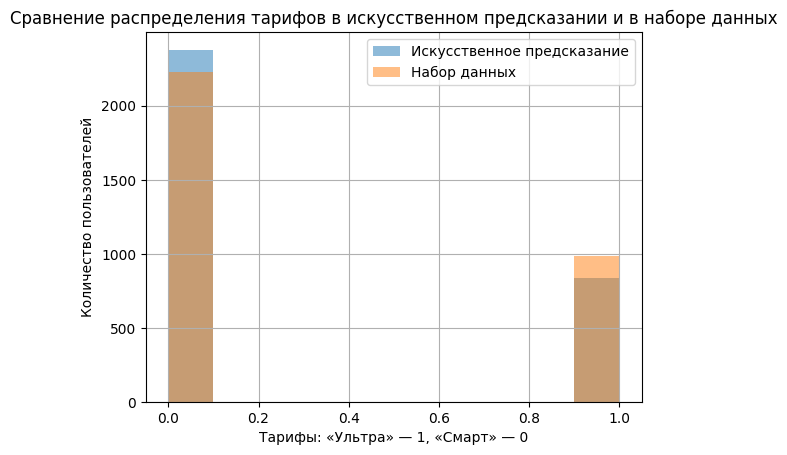

In [19]:
target_distr.hist(bins=10, alpha=0.5)
target.hist(bins=10,alpha=0.5)
plt.title('Сравнение распределения тарифов в искусственном предсказании и в наборе данных');

plt.legend(['Искусственное предсказание', 'Набор данных'])
plt.xlabel('Тарифы: «Ультра» — 1, «Смарт» — 0');
plt.ylabel('Количество пользователей');
plt.show;